# Assignment 6, #3: Tree Models' Prediction of Obesity Risk

Used models: Decision Tree, Bagged, Random Forest, Boosting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC, GradientBoostingClassifier as GBC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')

X = df.drop(['id','NObeyesdad'], axis=1)
y = df['NObeyesdad']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(exclude='object').columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
    ]
)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=55)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## Decision Tree

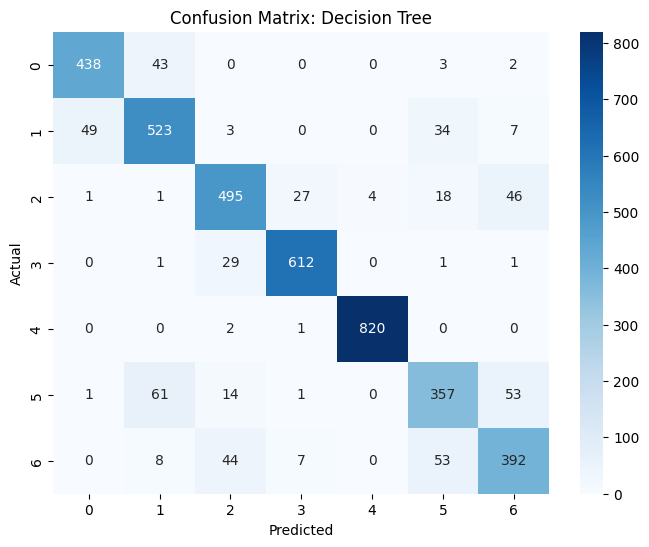

Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5}
Decision Tree Accuracy: 0.8760
Decision Tree Feature Importances:
                               Feature  Importance
2                               Weight    0.657307
8                          Gender_Male    0.157894
1                               Height    0.100004
0                                  Age    0.020463
5                                 CH2O    0.016108
3                                 FCVC    0.011083
4                                  NCP    0.008162
10                            FAVC_yes    0.005929
7                                  TUE    0.005148
6                                  FAF    0.004591
17                             CALC_no    0.004062
9   family_history_with_overweight_yes    0.003568
12                      CAEC_Sometimes    0.001291
16                      CALC_Sometimes    0.001241
11                     CAEC_Frequently    0.001056
20        MTRANS_Publi

In [2]:
param_grid_dt = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}
dt_classifier = DTC(random_state=55)
grid_search_dt = GridSearchCV(dt_classifier, param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train_processed, y_train)
clfdt = grid_search_dt.best_estimator_

y_pred_dt = clfdt.predict(X_test_processed)
plot_conf_matrix(y_test, y_pred_dt, "Decision Tree")
accscore = accuracy_score(y_test , y_pred_dt)
print(f"Best Decision Tree Parameters: {grid_search_dt.best_params_}")
print(f"Decision Tree Accuracy: {accscore:.4f}")

ohe = preprocessor.named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)
processed_feature_names = numerical_cols + ohe_feature_names.tolist()
feature_importance_df = pd.DataFrame({
    'Feature': processed_feature_names,
    'Importance': clfdt.feature_importances_
})
print("Decision Tree Feature Importances:")
print(feature_importance_df.sort_values(by='Importance', ascending=False))

Decision trees are non-parametric and do not assume any specific data distribution.  
They can handle both numerical and categorical data but small changes in the training data can lead to a significantly different tree structure. Decision trees are also prone to overfitting.  
The feature importance scores indicate which features were most influential in the decision-making process. Weight, Male gender, and Height are strong predictors of obesity risk.  
## Bagged

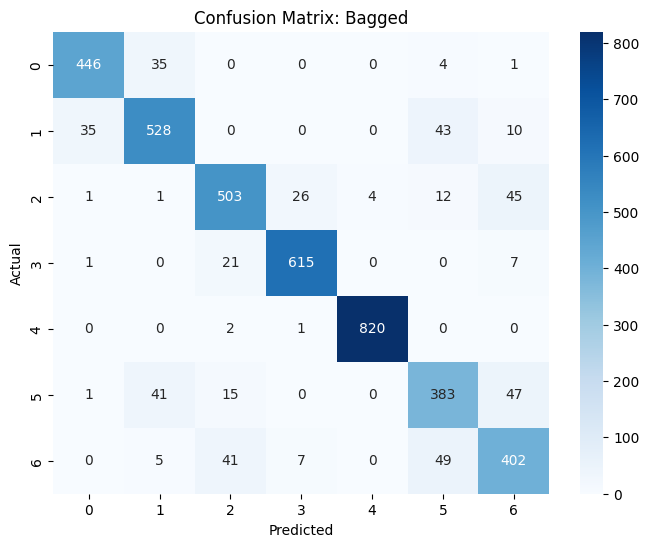

Best Bagged Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 200}
Bagged Accuracy: 0.8904
Bagged Feature Importances:
                               Feature  Importance
2                               Weight    0.455985
8                          Gender_Male    0.195440
1                               Height    0.146860
0                                  Age    0.055061
5                                 CH2O    0.027393
3                                 FCVC    0.018848
6                                  FAF    0.018254
4                                  NCP    0.017092
7                                  TUE    0.015265
10                            FAVC_yes    0.010494
17                             CALC_no    0.008141
9   family_history_with_overweight_yes    0.007299
16                      CALC_Sometimes    0.004328
11                     CAEC_Frequently    0.004211
20        MTRANS_Public_Transportation    0.003979
12                      CAEC_Sometimes    0.00

In [3]:
param_grid_bg = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 5]
}
bg_classifier = RFC(max_features=X_train_processed.shape[1], random_state=55, n_jobs=-1)
grid_search_bg = GridSearchCV(bg_classifier, param_grid_bg, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_bg.fit(X_train_processed, y_train)
clfbg = grid_search_bg.best_estimator_

y_pred_bg = clfbg.predict(X_test_processed)
plot_conf_matrix(y_test, y_pred_bg, "Bagged")
accscore = accuracy_score(y_test , y_pred_bg)
print(f"Best Bagged Parameters: {grid_search_bg.best_params_}")
print(f"Bagged Accuracy: {accscore:.4f}")

feature_importance_df = pd.DataFrame({
    'Feature': processed_feature_names,
    'Importance': clfbg.feature_importances_
})
print("Bagged Feature Importances:")
print(feature_importance_df.sort_values(by='Importance', ascending=False))

Bagging works well even with high-variance, low-bias base learners (like deep decision trees) as it focuses on reducing variance. Bagging requires sufficient data to create diverse bootstrap samples for the base estimators.  
Like the single decision tree, Weight, Male gender, and Height are the most important features. The aggregated importance from multiple trees provides a more robust estimate than a single tree.  
The assumption of sufficient data for diverse bootstrap samples is met by our dataset size.
## Random Forest

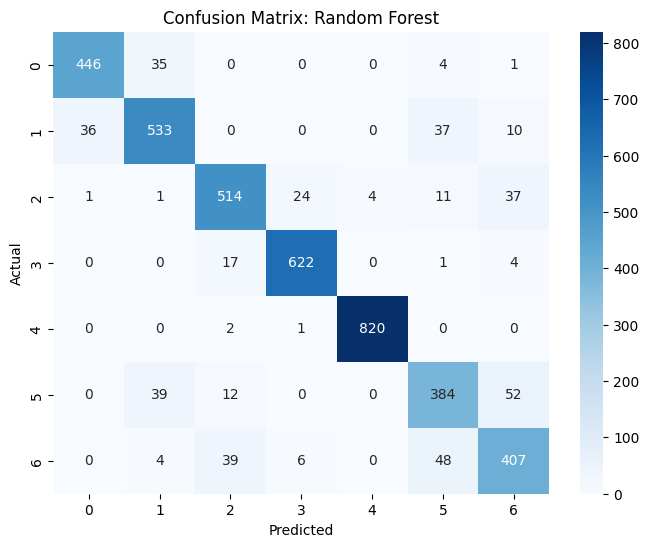

Best Random Forest Parameters: {'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 300}
Random Forest Accuracy: 0.8974
Random Forest Feature Importances:
                               Feature  Importance
2                               Weight    0.450241
1                               Height    0.117833
8                          Gender_Male    0.094355
3                                 FCVC    0.085804
0                                  Age    0.077895
7                                  TUE    0.028340
5                                 CH2O    0.026273
6                                  FAF    0.022448
4                                  NCP    0.022055
9   family_history_with_overweight_yes    0.017534
17                             CALC_no    0.010012
11                     CAEC_Frequently    0.009618
10                            FAVC_yes    0.009460
16                      CALC_Sometimes    0.007916
12                      CAEC_Sometimes    0.005805
20  

In [4]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 5],
    'max_features': ['sqrt', 'log2', 0.5]
}
rf_classifier = RFC(random_state=55, n_jobs=-1)
grid_search_rf = GridSearchCV(rf_classifier, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train_processed, y_train)
clfrf = grid_search_rf.best_estimator_

y_pred_rf = clfrf.predict(X_test_processed)
plot_conf_matrix(y_test, y_pred_rf, "Random Forest")
accscore = accuracy_score(y_test , y_pred_rf)
print(f"Best Random Forest Parameters: {grid_search_rf.best_params_}")
print(f"Random Forest Accuracy: {accscore:.4f}")

feature_importance_df = pd.DataFrame({
    'Feature': processed_feature_names,
    'Importance': clfrf.feature_importances_
})
print("Random Forest Feature Importances:")
print(feature_importance_df.sort_values(by='Importance', ascending=False))

Random forest shares assumptions with bagging, including the reduction of variance through ensemble averaging. Similar to bagging, sufficient data is beneficial for creating diverse trees. While Random Forests are more robust to multicollinearity than single decision trees, extreme multicollinearity can still lead to less interpretable feature importances.  
Random Forest's feature importances are generally more stable and reliable than those from a single decision tree. They confirm the top features as Weight, Height, and Male gender, with FCVC (Frequency of consumption of vegetables) and Age also showing significance.  
The assumption of sufficient data for diverse bootstrap samples is met by our dataset size.
## Boosting

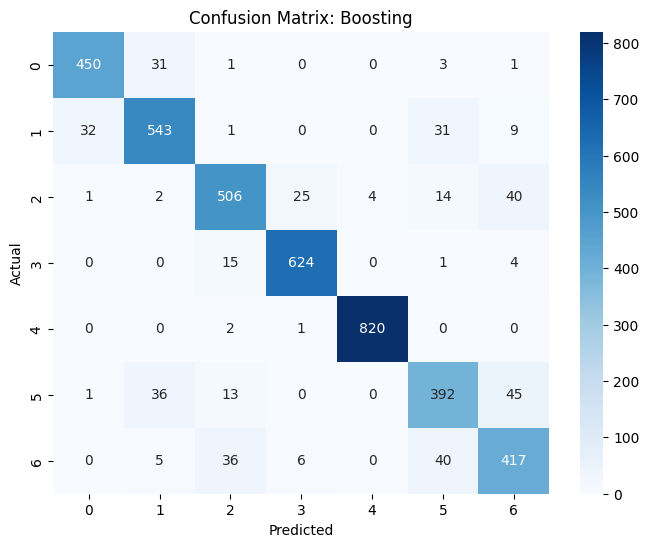

Best Boosting Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.8}
Boosting Accuracy: 0.9037
Boosting Feature Importances:
                               Feature  Importance
2                               Weight    0.601800
3                                 FCVC    0.108999
8                          Gender_Male    0.097173
1                               Height    0.076869
0                                  Age    0.039597
5                                 CH2O    0.015891
17                             CALC_no    0.015315
4                                  NCP    0.011619
7                                  TUE    0.007637
13                             CAEC_no    0.006638
6                                  FAF    0.005766
10                            FAVC_yes    0.004254
9   family_history_with_overweight_yes    0.002001
15                             SCC_yes    0.001986
11                     CAEC_Frequently    0.001687
12                    

In [5]:
param_grid_gb = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.001, 0.01],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}
gb_classifier = GBC(random_state=55)
grid_search_gb = GridSearchCV(gb_classifier, param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_gb.fit(X_train_processed, y_train)
clfgb = grid_search_gb.best_estimator_

y_pred_gb = clfgb.predict(X_test_processed)
plot_conf_matrix(y_test, y_pred_gb, "Boosting")
accscore = accuracy_score(y_test , y_pred_gb)
print(f"Best Boosting Parameters: {grid_search_gb.best_params_}")
print(f"Boosting Accuracy: {accscore:.4f}")

feature_importance_df = pd.DataFrame({
    'Feature': processed_feature_names,
    'Importance': clfgb.feature_importances_
})
print("Boosting Feature Importances:")
print(feature_importance_df.sort_values(by='Importance', ascending=False))

Gradient Boosting minimizes a loss function using gradient descent. Boosted models can be sensitive to noisy data and outliers, and more prone to overfitting if not carefully tuned.  
Boosting model shows Weight, Height, FCVC, and Male Gender as important features.  
Ensemble methods like Random Forest and Gradient Boosting Classifier offer superior performance compared to a single Decision Tree.

In [6]:
test_df = pd.read_csv("/kaggle/input/playground-series-s4e2/test.csv")
test_ids = test_df["id"]
test_df_X = test_df.drop('id', axis=1)
X_test_proc = preprocessor.transform(test_df_X)

y_dt_preds = clfdt.predict(X_test_proc)
y_bg_preds = clfbg.predict(X_test_proc)
y_rf_preds = clfrf.predict(X_test_proc)
y_gb_preds = clfgb.predict(X_test_proc)
y_dt_preds = np.maximum(0, y_dt_preds)
y_bg_preds = np.maximum(0, y_bg_preds)
y_rf_preds = np.maximum(0, y_rf_preds)
y_gb_preds = np.maximum(0, y_gb_preds)

submission = pd.DataFrame({'id': test_ids, 'NObeyesdad': y_dt_preds})
submission.to_csv("submission_dt.csv", index=False)
print("Submissions (decision tree) saved: submission_dt.csv")
submission = pd.DataFrame({'id': test_ids, 'NObeyesdad': y_bg_preds})
submission.to_csv("submission_bg.csv", index=False)
print("Submissions (bagged) saved: submission_bg.csv")
submission = pd.DataFrame({'id': test_ids, 'NObeyesdad': y_rf_preds})
submission.to_csv("submission_rf.csv", index=False)
print("Submissions (random forest) saved: submission_rf.csv")
submission = pd.DataFrame({'id': test_ids, 'NObeyesdad': y_gb_preds})
submission.to_csv("submission_gb.csv", index=False)
print("Submissions (boosting) saved: submission_gb.csv")

Submissions (decision tree) saved: submission_dt.csv
Submissions (bagged) saved: submission_bg.csv
Submissions (random forest) saved: submission_rf.csv
Submissions (boosting) saved: submission_gb.csv
